In [33]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

# __Appendix 3__ | Modeling

### __Load models__

In [34]:
%run utility/stan_utility.py # Utilities by Betancourt

#### Import data

In [35]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
names_2018 = ['streams', 'acousticness', 'danceability', 'loudness', 'tempo', 'valence']

global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
global_data_2018 = pd.read_csv('./data/2018_global_selected.csv',header=None, names=names)

#### Select top 30 

In [36]:
global_data = global_data[0:30]
global_data_2018 = global_data_2018[0:30]

#### Log transform the $Y$:

In [37]:
global_data['streams'] = np.log10(global_data['streams'])

#### Define method for calculating and combining LOO scores:

In [38]:
def extract_azfit(fit, prior_dict):
    azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                           observed_data='y', 
                           posterior_predictive='ypred', 
                           log_likelihood='log_lik')
    return azfit

In [39]:
def calculate_and_print_loo(fit, loos):
    prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
    
    azfit = extract_azfit(fit, prior_dict)
    loo_m = az.loo(azfit)
    loo_m['Model'] = model_name
    loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
    loos = loos.append(loo_m, sort=True)
    
    return loo_m.set_index('Model'), loos 

#### Fit all 8 models:

In [40]:
model_filenames = ['lin_3_uninformative.stan',
                   'lin_3_informative.stan',
                   'lin_5_informative.stan',
                   'lin_5_informative-interaction.stan',
                   'lin_5_informative-interaction2.stan',
                   'lin_5_informative-second_order.stan',
                   'lin_5_informative-second_order-inter.stan',
                   'lin_5_informative-third_order-inter.stan']

model_names = ['Linear; 3 Predictors Uninformative ',
               'Linear; 3 Predictors Weakly Informative, Normal ',
               'Linear; 5 Predictors Weakly Informative, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative inter 1, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative inter 2, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative squared, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative squared inter, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative cubic, Normal ']

column_names = ['Predictors', 'type', 'Interaction terms', 'Squared terms', 'Cubic terms']

num_predictors = [3,3,5,5,5,5,5,5]
inter_terms = [0,0,0,2,4,2,4,4]
squared_terms = [False,False,False,False,False,True,True,True]
cubic_terms = [False,False,False,False,False,False,False,True]

types = ['Linear', 'Linear', 'Linear', 'Non-linear', 'Non-linear', 'Non-linear', 'Non-linear', 'Non-linear']

column_values = [num_predictors, types, inter_terms, squared_terms, cubic_terms]

loos = pd.DataFrame(index=[], columns=["loo", "warning", "treedepth", "div"])
nums_b = [3,3,5,7,9,12,14,19]
fits = []

In [41]:
for filename, num_b, model_name in zip(model_filenames, nums_b, model_names):
    filename = './models/{0}'.format(filename)
    with open(filename, 'r') as file:
        
        gb_2017 = global_data.values
        gb_2018 = global_data_2018.values 
            
        data = dict(N=gb_2017.shape[0],
                    y=gb_2017[:,0],
                    X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
                    Npred=gb_2018.shape[0], 
                    X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
                    mu_a=0,
                    mu_b=np.zeros(num_b),
                    sigma_0=0.12*10)

        model = compile_model(filename, model_name=model_name) 
        fit = model.sampling(data=data, seed=2222)
        fits.append(fit)
        div_check, tree_check, energy_check = pystan.diagnostics.check_div(fit, verbose = 2), pystan.diagnostics.check_treedepth(fit, verbose = 2), pystan.diagnostics.check_energy(fit, verbose = 2)        
        p, loos = calculate_and_print_loo(fit,loos)
        

Using cached StanModel


INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.0573821762908888) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.0606463186890898) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.0736903822724433) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.0482494474189668) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
      

Using cached StanModel


INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.9343322963365545) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.8170282140068038) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9390014825990785) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.1019708349372057) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
      

Using cached StanModel


INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.9564623592315054) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9672673232554609) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9832443135111536) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.9978494973684098) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
      

Using cached StanModel


INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.8237815579637572) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9012550378275727) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9055719806244973) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.896415943488469) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sam

Using cached StanModel


INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.763296018790109) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9167053101127984) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.8184331019442744) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.841979101240947) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


Using cached StanModel


/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.7381898655149954) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.8174889229056169) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.7174402472426025) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.7302784089099504) equals or exceeds threshold of 

Using cached StanModel


/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.730618799088771) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.7283363367010024) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.6865755753667838) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.6949961585699211) equals or exceeds threshold of 0

Using cached StanModel


/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.517816618437203) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.4887805061556729) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.5423704454622931) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.4258053630953285) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no patholog

### __Results__

#### __Results calculated with__ `az.loo` + HMC checks

First results are computed using Arviz's `loo` method and diagnostics using `pystan.diagnostics` 

In [42]:
loos_file = loos.set_index('Model')
loos_file

div energy        loo  \
Model                                                                         
Linear; 3 Predictors Uninformative                   True   True -46.789744   
Linear; 3 Predictors Weakly Informative, Normal      True   True -46.595292   
Linear; 5 Predictors Weakly Informative, Normal      True   True -43.532014   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -47.092808   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -53.465016   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -39.476162   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -46.230376   
Non-Linear; 5 Predictors Weakly Informative cub...  False   True -45.809768   

                                                       loo_se      p_loo  \
Model                                                                      
Linear; 3 Predictors Uninformative                  14.399818   7.472757   
Linear; 3 Predictors Weakly Informative, Normal     14.463721   7.459724   
Linear; 5 Predictors Weakly Informative, Normal     17.536499  10.090500   
Non-Linear; 5 Predictors Weakly Informative int...  12.470337   9.972529   
Non-Linear; 5 Predictors Weakly Informative int...   8.360274  10.999715   
Non-Linear; 5 Predictors Weakly Informative squ...  11.408436  13.941789   
Non-Linear; 5 Predictors Weakly Informative squ...   7.160623  14.226961   
Non-Linear; 5 Predictors Weakly Informative cub...   4.883082  18.317032   

                                                   treedepth warning  
Model                                                                 
Linear; 3 Predictors Uninformative                      True       1  
Linear; 3 Predictors Weakly Informative, Normal         True       1  
Linear; 5 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Non-Linear; 5 Predictors Weakly Informative cub...      True       1

#### __Sorted by `LOO`-column__

In [43]:
#loos_file = loos.set_index('Model')
loos_file.sort_values(by='loo')

div energy        loo  \
Model                                                                         
Non-Linear; 5 Predictors Weakly Informative int...   True   True -53.465016   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -47.092808   
Linear; 3 Predictors Uninformative                   True   True -46.789744   
Linear; 3 Predictors Weakly Informative, Normal      True   True -46.595292   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -46.230376   
Non-Linear; 5 Predictors Weakly Informative cub...  False   True -45.809768   
Linear; 5 Predictors Weakly Informative, Normal      True   True -43.532014   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -39.476162   

                                                       loo_se      p_loo  \
Model                                                                      
Non-Linear; 5 Predictors Weakly Informative int...   8.360274  10.999715   
Non-Linear; 5 Predictors Weakly Informative int...  12.470337   9.972529   
Linear; 3 Predictors Uninformative                  14.399818   7.472757   
Linear; 3 Predictors Weakly Informative, Normal     14.463721   7.459724   
Non-Linear; 5 Predictors Weakly Informative squ...   7.160623  14.226961   
Non-Linear; 5 Predictors Weakly Informative cub...   4.883082  18.317032   
Linear; 5 Predictors Weakly Informative, Normal     17.536499  10.090500   
Non-Linear; 5 Predictors Weakly Informative squ...  11.408436  13.941789   

                                                   treedepth warning  
Model                                                                 
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Linear; 3 Predictors Uninformative                      True       1  
Linear; 3 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Non-Linear; 5 Predictors Weakly Informative cub...      True       1  
Linear; 5 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1

In [44]:
prior_dicts = [M.extract(pars=['a','b','sigma'], permuted=False) for M in fits]
azfits = [extract_azfit(M, prior_dicts[i]) for i,M in enumerate(fits)]

In [45]:
comparison = az.compare(dict(zip(model_names, azfits)), ic='loo')
for col in column_names:
    comparison[col] = None

for i,name in enumerate(model_names):
    for j,col in enumerate(column_names):
        comparison.loc[name, col] = column_values[j][i] 

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
   

#### __Results calculated with__ `az.compare`

In [46]:
comparison

loo     ploo     dloo  \
Non-Linear; 5 Predictors Weakly Informative int...  -53.465  10.9997        0   
Non-Linear; 5 Predictors Weakly Informative int... -47.0928  9.97253  6.37221   
Linear; 3 Predictors Uninformative                 -46.7897  7.47276  6.67527   
Linear; 3 Predictors Weakly Informative, Normal    -46.5953  7.45972  6.86972   
Non-Linear; 5 Predictors Weakly Informative squ... -46.2304   14.227  7.23464   
Non-Linear; 5 Predictors Weakly Informative cub... -45.8098   18.317  7.65525   
Linear; 5 Predictors Weakly Informative, Normal     -43.532  10.0905    9.933   
Non-Linear; 5 Predictors Weakly Informative squ... -39.4762  13.9418  13.9889   

                                                         weight       se  \
Non-Linear; 5 Predictors Weakly Informative int...      0.40142  8.36027   
Non-Linear; 5 Predictors Weakly Informative int...  1.78734e-14  12.4703   
Linear; 3 Predictors Uninformative                     0.414877  14.3998   
Linear; 3 Predictors Weakly Informative, Normal     1.50941e-13  14.4637   
Non-Linear; 5 Predictors Weakly Informative squ...  3.45834e-16  7.16062   
Non-Linear; 5 Predictors Weakly Informative cub...     0.164279  4.88308   
Linear; 5 Predictors Weakly Informative, Normal       0.0194241  17.5365   
Non-Linear; 5 Predictors Weakly Informative squ...            0  11.4084   

                                                        dse warning  \
Non-Linear; 5 Predictors Weakly Informative int...        0       1   
Non-Linear; 5 Predictors Weakly Informative int...  7.91712       1   
Linear; 3 Predictors Uninformative                  10.2814       1   
Linear; 3 Predictors Weakly Informative, Normal     10.4211       1   
Non-Linear; 5 Predictors Weakly Informative squ...  3.28259       1   
Non-Linear; 5 Predictors Weakly Informative cub...  7.70604       1   
Linear; 5 Predictors Weakly Informative, Normal     12.9946       1   
Non-Linear; 5 Predictors Weakly Informative squ...  7.85474       1   

                                                   Predictors        type  \
Non-Linear; 5 Predictors Weakly Informative int...          5  Non-linear   
Non-Linear; 5 Predictors Weakly Informative int...          5  Non-linear   
Linear; 3 Predictors Uninformative                          3      Linear   
Linear; 3 Predictors Weakly Informative, Normal             3      Linear   
Non-Linear; 5 Predictors Weakly Informative squ...          5  Non-linear   
Non-Linear; 5 Predictors Weakly Informative cub...          5  Non-linear   
Linear; 5 Predictors Weakly Informative, Normal             5      Linear   
Non-Linear; 5 Predictors Weakly Informative squ...          5  Non-linear   

                                                   Interaction terms  \
Non-Linear; 5 Predictors Weakly Informative int...                 4   
Non-Linear; 5 Predictors Weakly Informative int...                 2   
Linear; 3 Predictors Uninformative                                 0   
Linear; 3 Predictors Weakly Informative, Normal                    0   
Non-Linear; 5 Predictors Weakly Informative squ...                 4   
Non-Linear; 5 Predictors Weakly Informative cub...                 4   
Linear; 5 Predictors Weakly Informative, Normal                    0   
Non-Linear; 5 Predictors Weakly Informative squ...                 2   

                                                   Squared terms Cubic terms  
Non-Linear; 5 Predictors Weakly Informative int...         False       False  
Non-Linear; 5 Predictors Weakly Informative int...         False       False  
Linear; 3 Predictors Uninformative                         False       False  
Linear; 3 Predictors Weakly Informative, Normal            False       False  
Non-Linear; 5 Predictors Weakly Informative squ...          True       False  
Non-Linear; 5 Predictors Weakly Informative cub...          True        True  
Linear; 5 Predictors Weakly Informative, Normal            False       False  
Non-Linear; 5 Predictors W

#### __Posterior predictive checks__

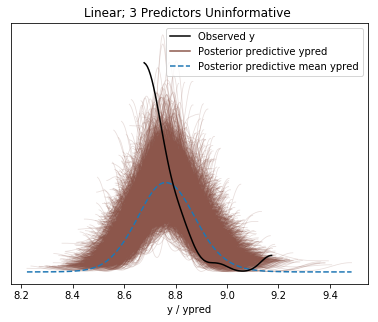

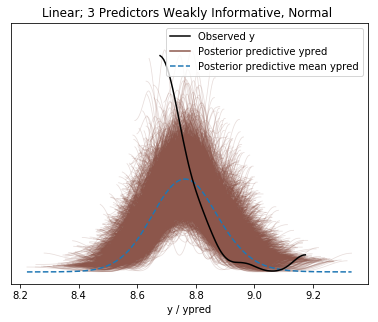

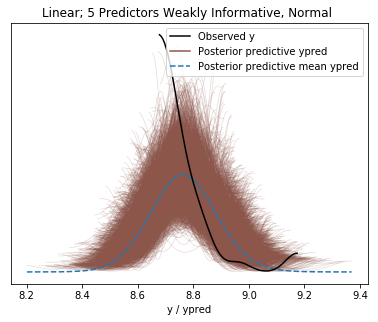

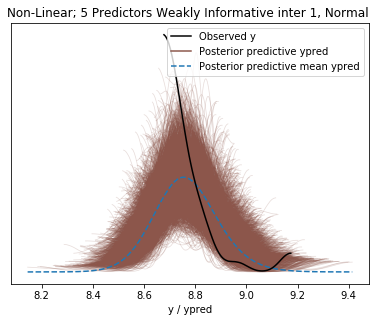

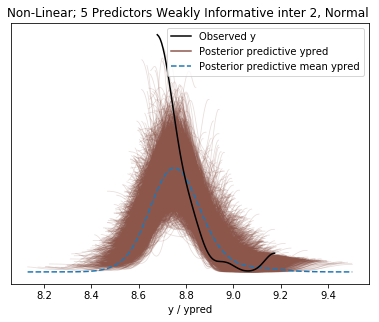

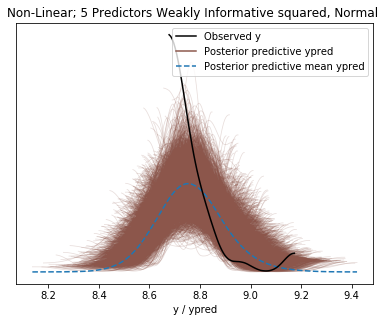

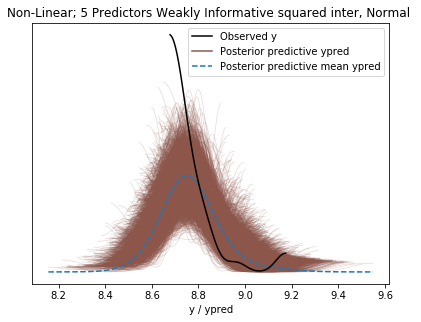

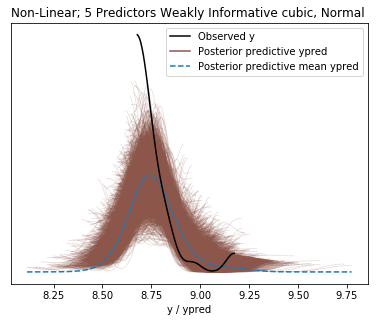

In [47]:
for M,name in zip(azfits,model_names):
    az.plot_ppc(M, data_pairs = {'y' : 'ypred'})
    plt.title(name)

### __Traces__

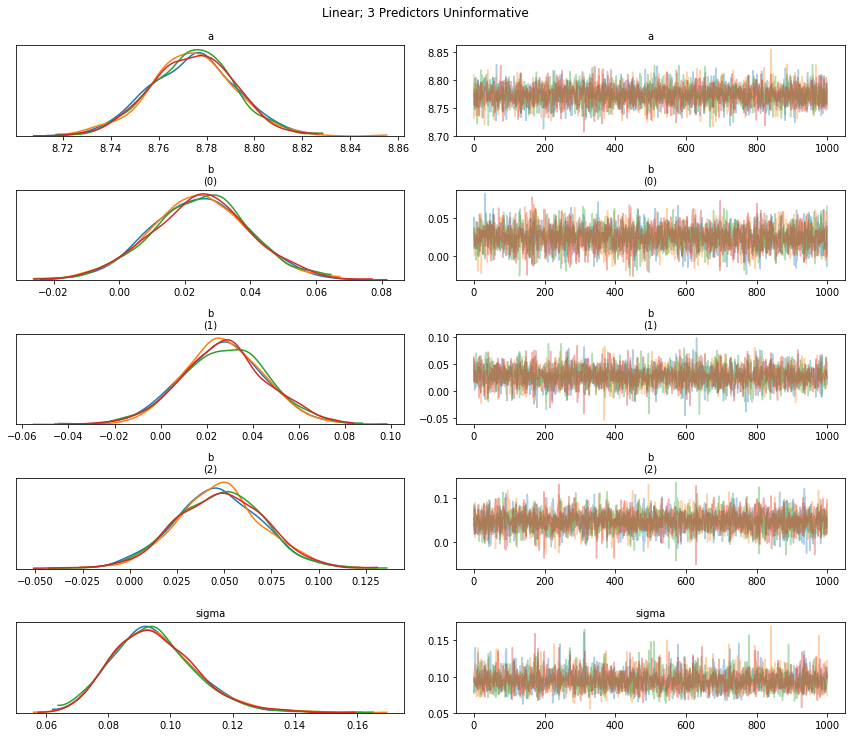

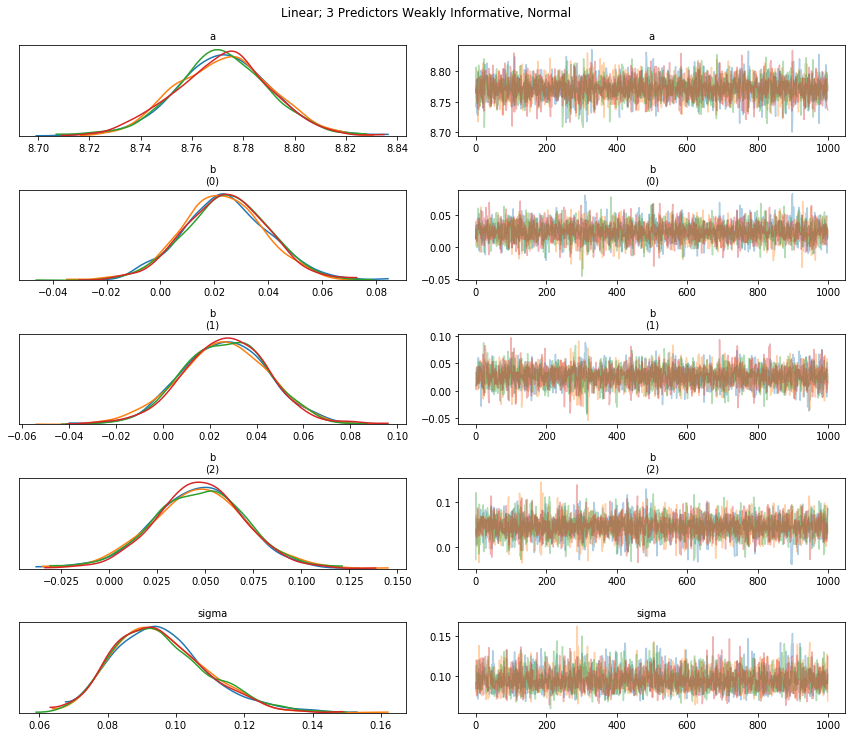

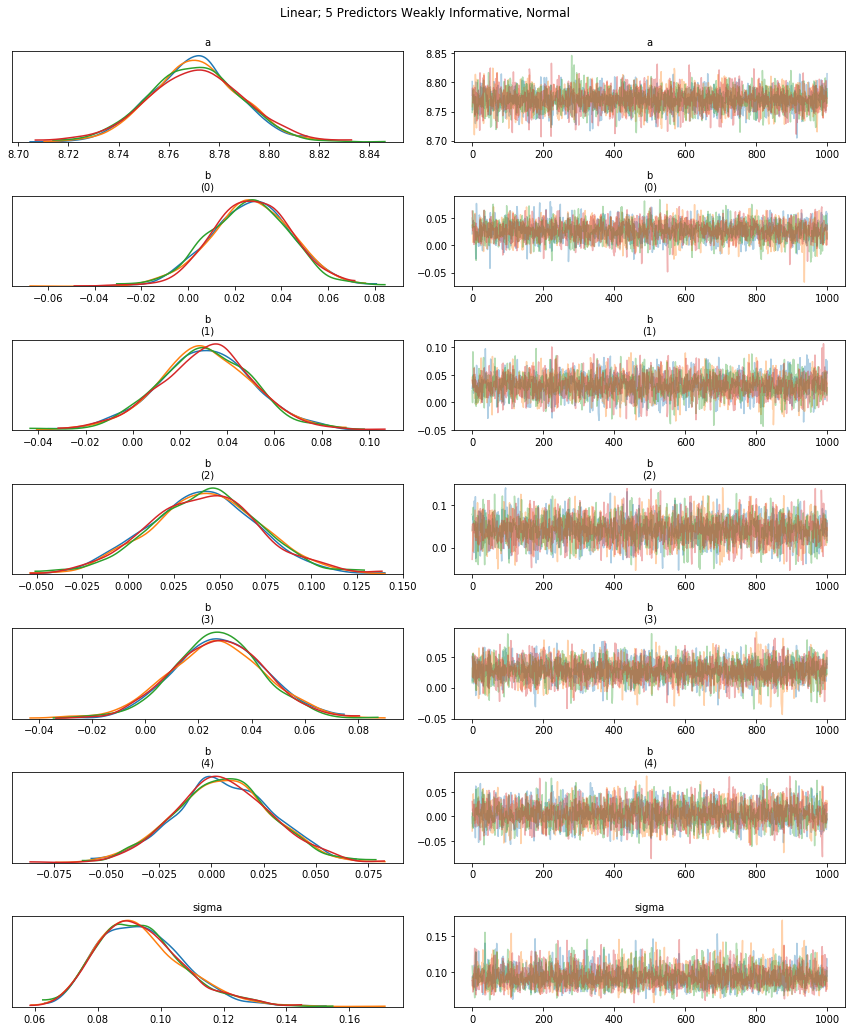

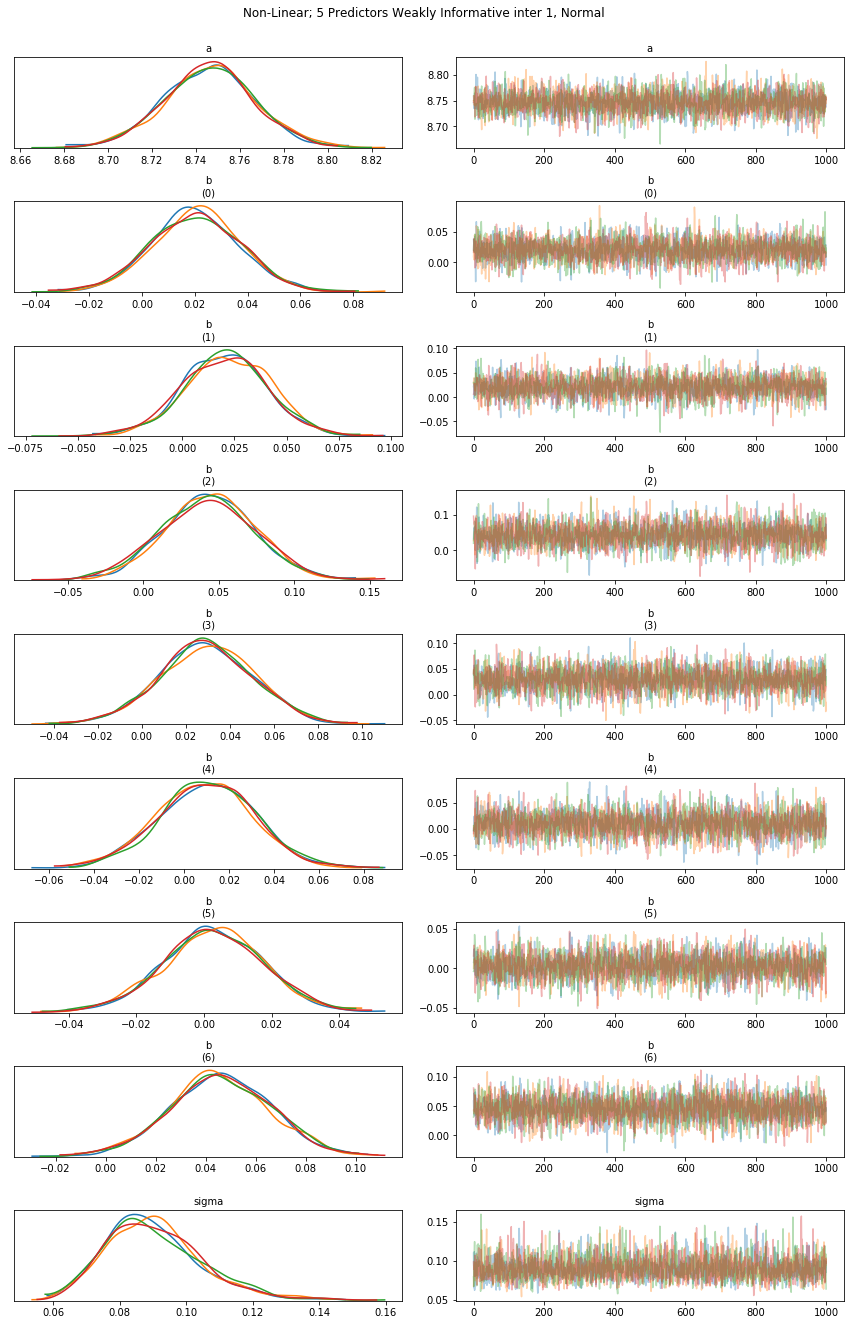

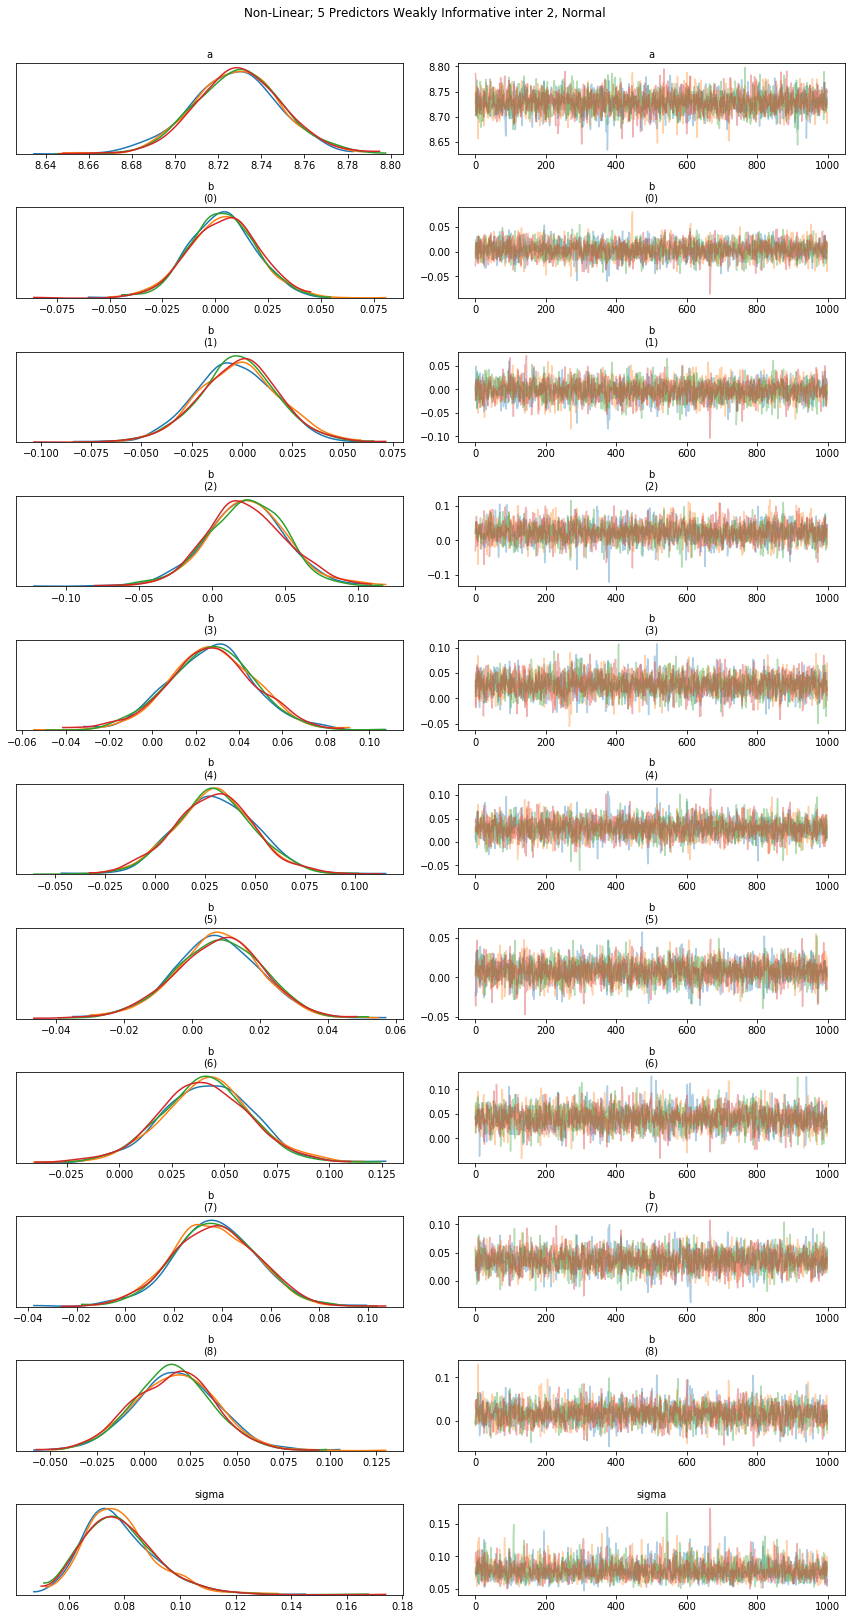

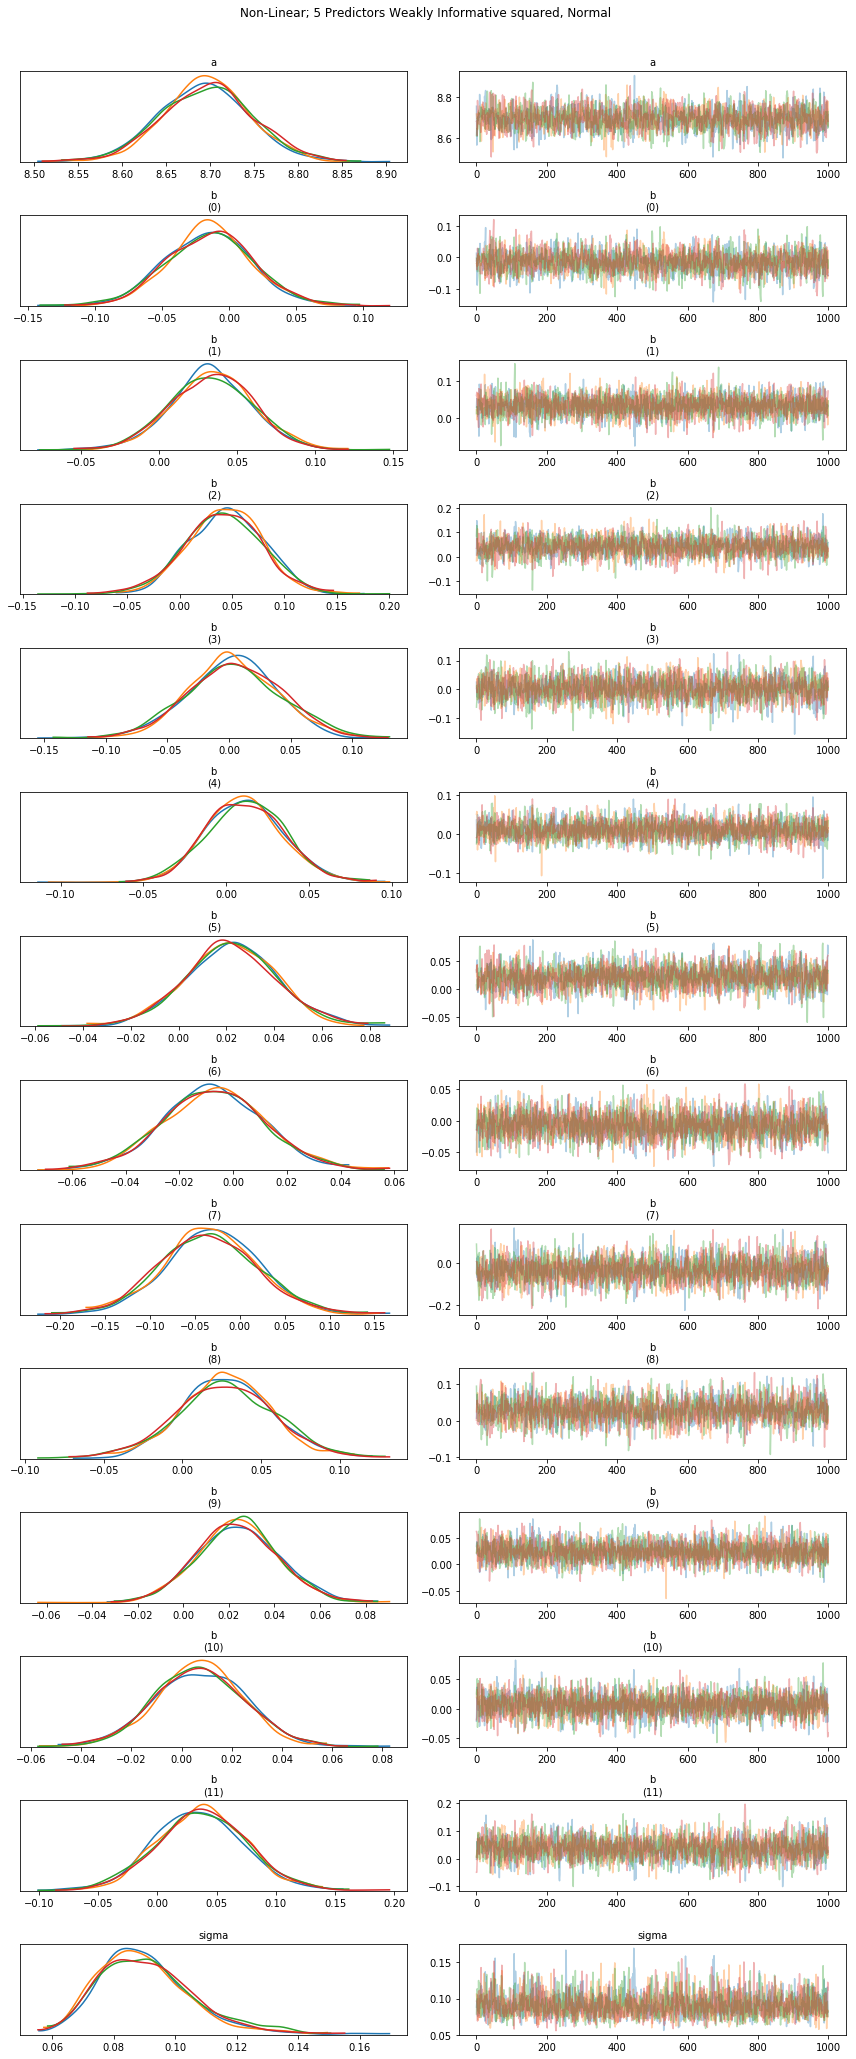

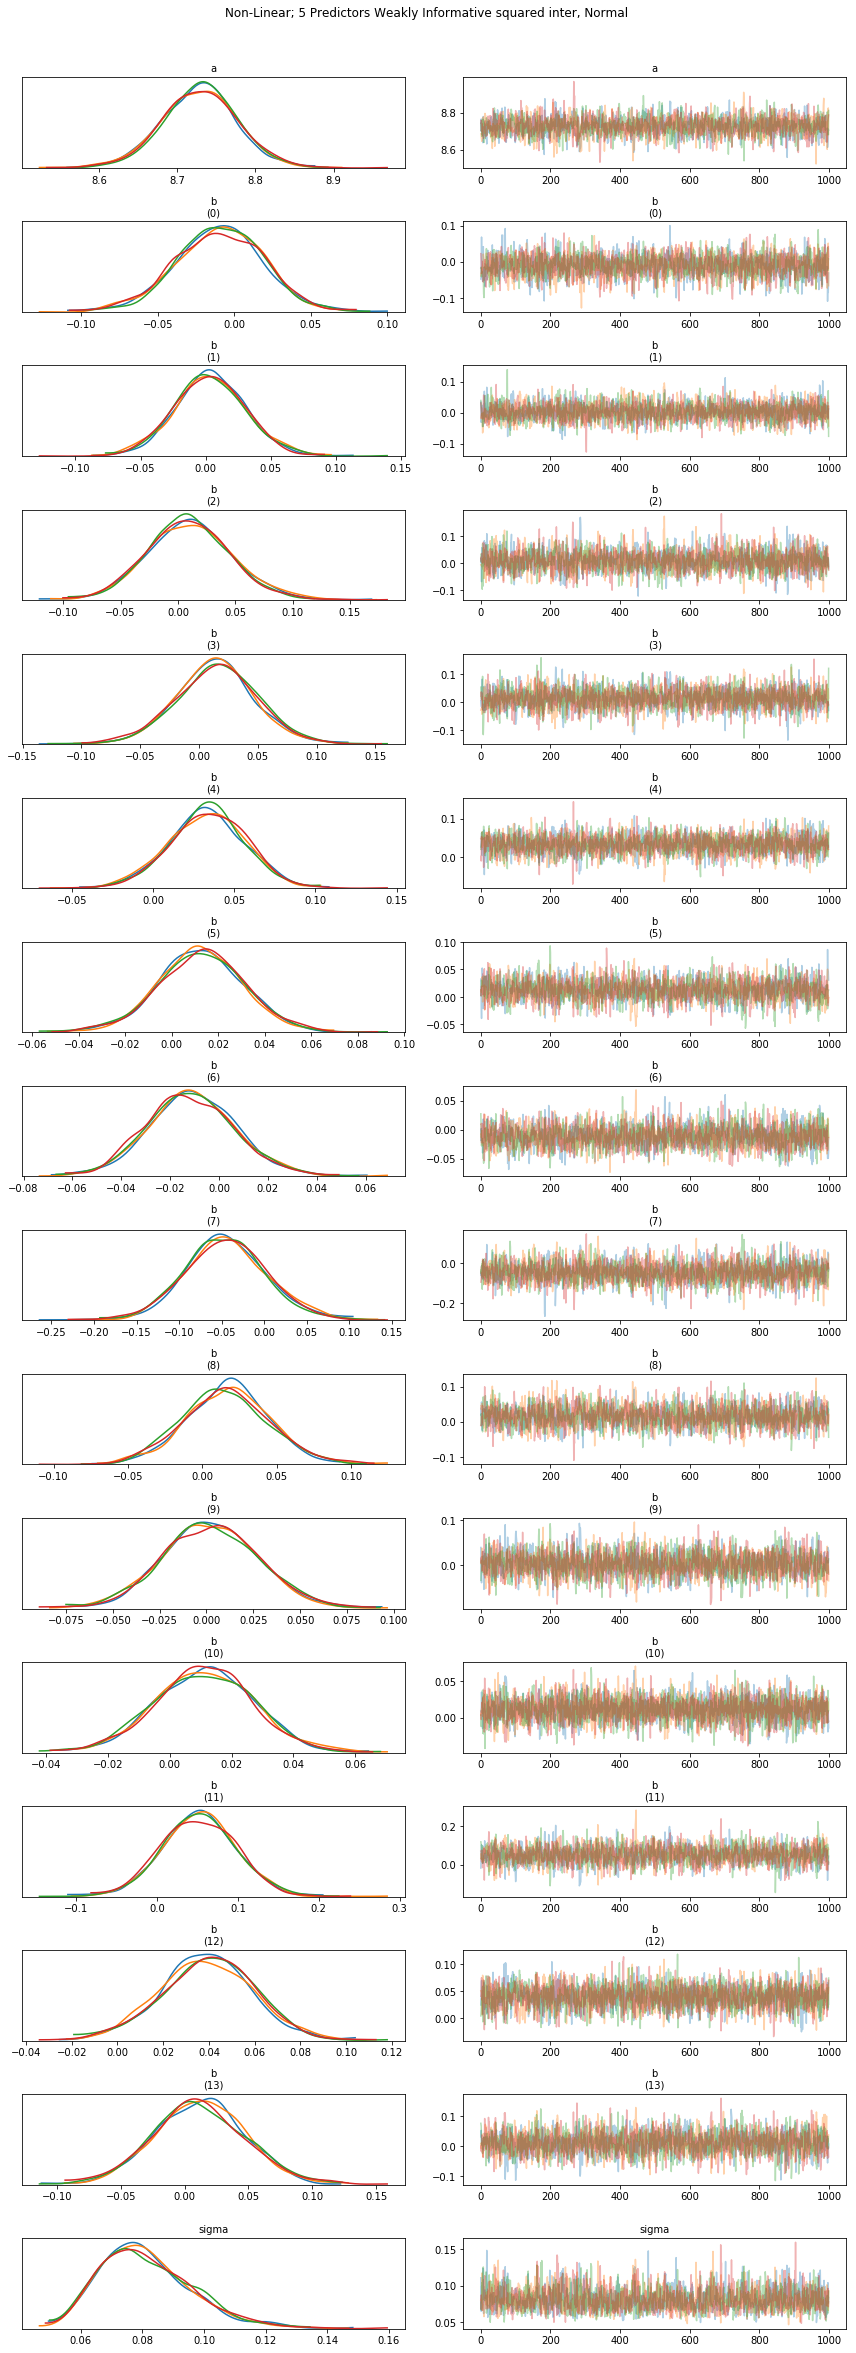

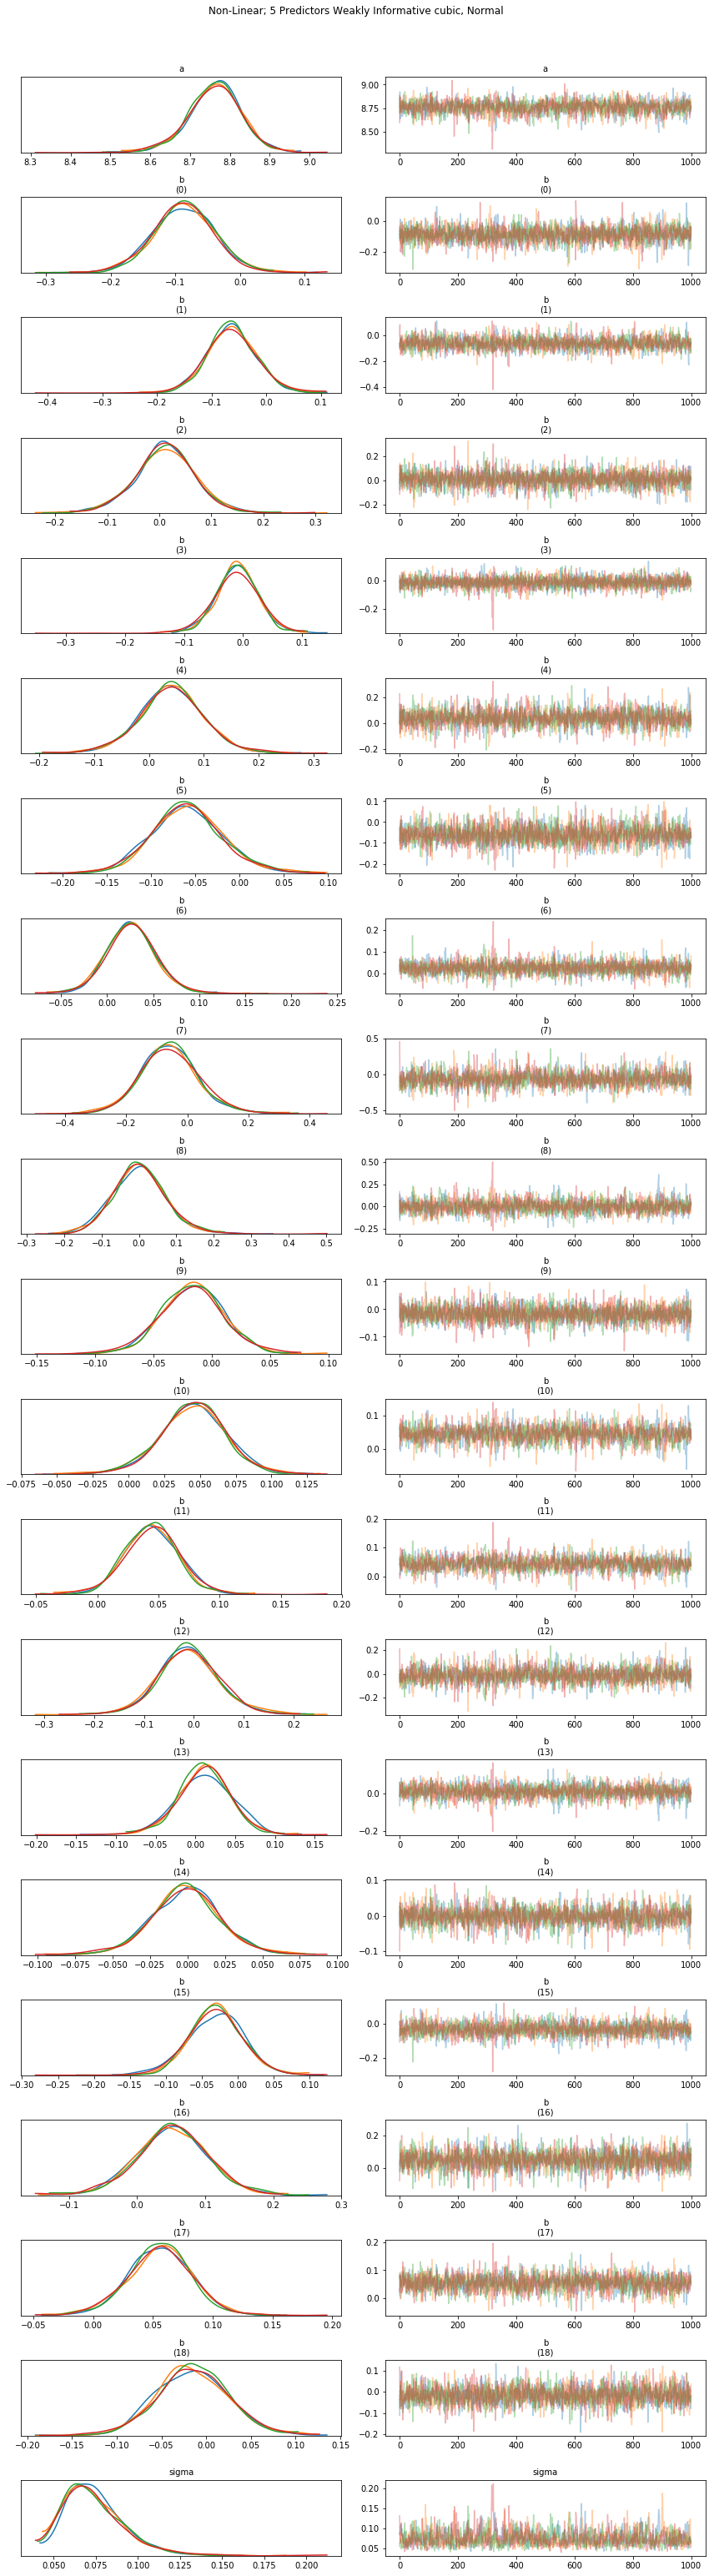

In [48]:
import time
for M, name in zip(azfits, model_names):
    azpos = M.posterior[['a','b','sigma']]
    az.plot_trace(azpos)
    plt.suptitle(name, y=1.02)
    time.sleep(0.02)


### __Pareto k values__

In [49]:
# Import PSIS from local directory, original code: https://github.com/avehtari/PSIS
%run PSIS/py/psis.py

In [50]:
def plot_ks(model_names, kss):
    legends = model_names
    N = len(fits) + 1
    plt.figure(figsize=(12,N*5))
    plt.suptitle('Pareto k values for the data', y=0.89)
    
    X = np.arange(0,31)
    Y = np.full(31, 0.7)
    plt.ylabel('k')
    plt.xlabel('Observation')
    for i,ks,lab in zip(range(1,N), kss, legends):
        ax = plt.subplot(N,1,i)
        #ax.set_ylim(0,1)
        ax.set_ylabel('Pareto k')
        ax.set_xlabel('Observation')
        ax.plot(X, Y, '--', alpha=.5, color='red')
        ax.plot(range(1,31), ks, 'o', label=lab, alpha=.6)
        ax.legend(loc='best')

In [51]:
kss = []
for M,name in zip(fits, model_names):
    loo, looss, ks = psisloo(M['log_lik'])
    kss.append(ks)

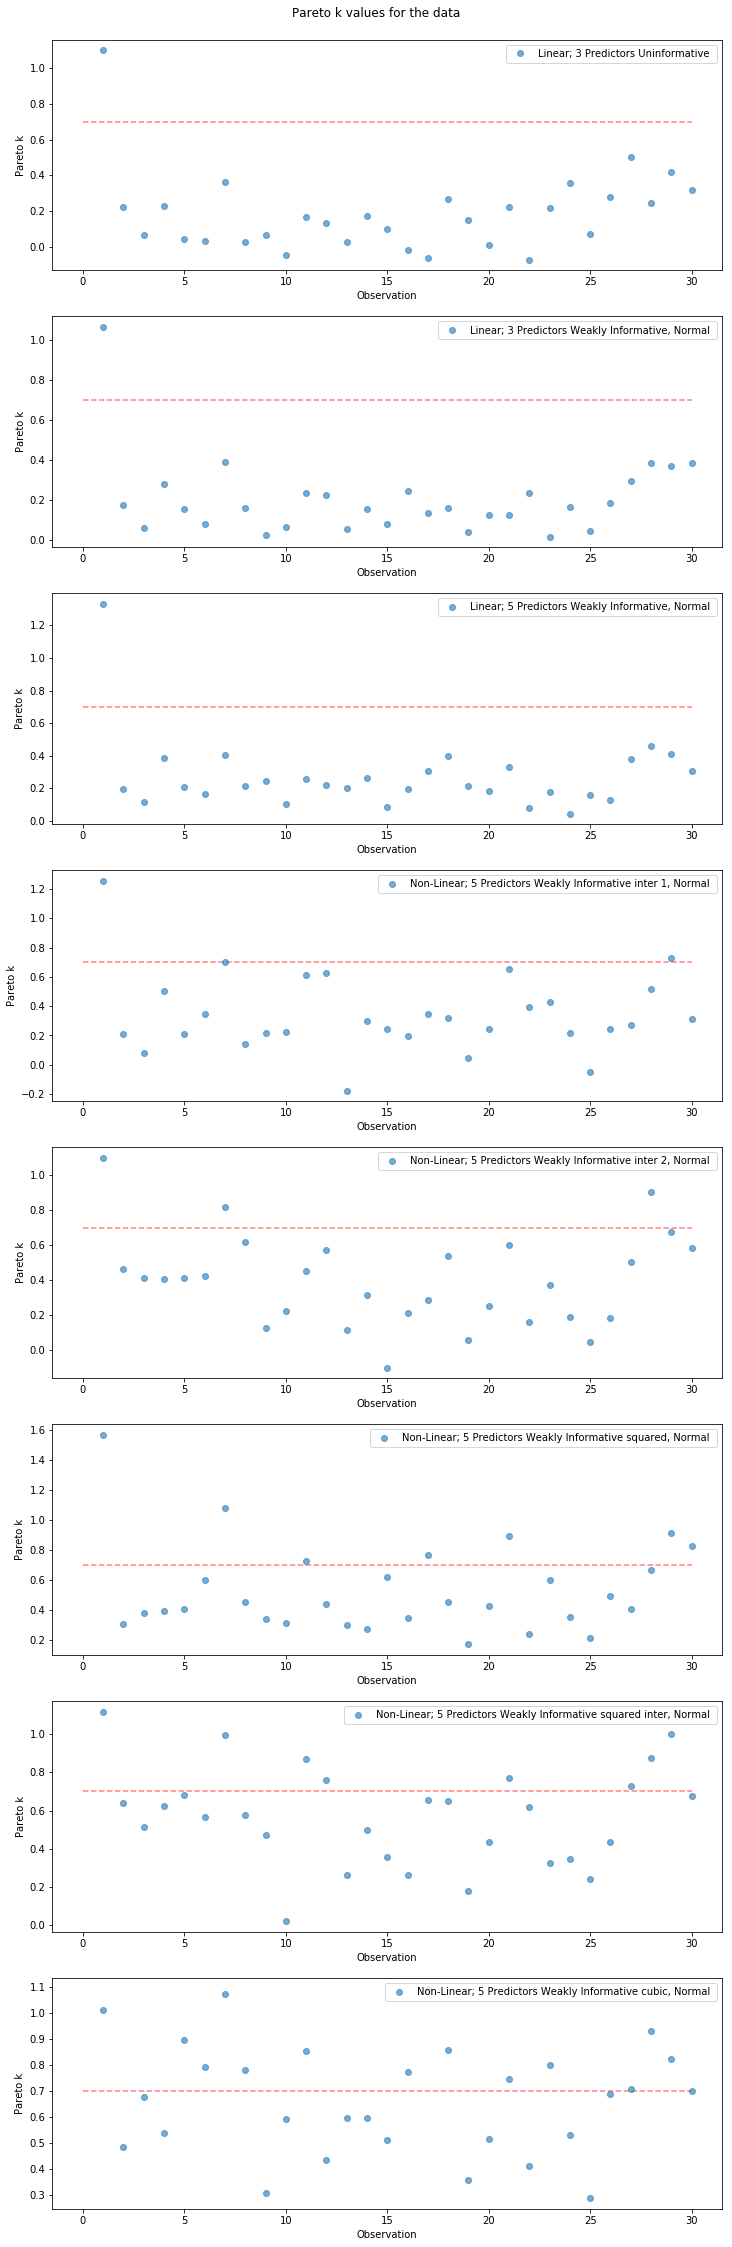

In [52]:
plot_ks(model_names, kss)

In [53]:
for name,ks in zip(model_names,kss):
    comparison.loc[name, 'k>0.7'] = np.sum(ks > 0.7)

In [54]:
comparison.to_csv('./comparisons/comparison.csv')
comparison

loo     ploo     dloo  \
Non-Linear; 5 Predictors Weakly Informative int...  -53.465  10.9997        0   
Non-Linear; 5 Predictors Weakly Informative int... -47.0928  9.97253  6.37221   
Linear; 3 Predictors Uninformative                 -46.7897  7.47276  6.67527   
Linear; 3 Predictors Weakly Informative, Normal    -46.5953  7.45972  6.86972   
Non-Linear; 5 Predictors Weakly Informative squ... -46.2304   14.227  7.23464   
Non-Linear; 5 Predictors Weakly Informative cub... -45.8098   18.317  7.65525   
Linear; 5 Predictors Weakly Informative, Normal     -43.532  10.0905    9.933   
Non-Linear; 5 Predictors Weakly Informative squ... -39.4762  13.9418  13.9889   

                                                         weight       se  \
Non-Linear; 5 Predictors Weakly Informative int...      0.40142  8.36027   
Non-Linear; 5 Predictors Weakly Informative int...  1.78734e-14  12.4703   
Linear; 3 Predictors Uninformative                     0.414877  14.3998   
Linear; 3 Predictors Weakly Informative, Normal     1.50941e-13  14.4637   
Non-Linear; 5 Predictors Weakly Informative squ...  3.45834e-16  7.16062   
Non-Linear; 5 Predictors Weakly Informative cub...     0.164279  4.88308   
Linear; 5 Predictors Weakly Informative, Normal       0.0194241  17.5365   
Non-Linear; 5 Predictors Weakly Informative squ...            0  11.4084   

                                                        dse warning  \
Non-Linear; 5 Predictors Weakly Informative int...        0       1   
Non-Linear; 5 Predictors Weakly Informative int...  7.91712       1   
Linear; 3 Predictors Uninformative                  10.2814       1   
Linear; 3 Predictors Weakly Informative, Normal     10.4211       1   
Non-Linear; 5 Predictors Weakly Informative squ...  3.28259       1   
Non-Linear; 5 Predictors Weakly Informative cub...  7.70604       1   
Linear; 5 Predictors Weakly Informative, Normal     12.9946       1   
Non-Linear; 5 Predictors Weakly Informative squ...  7.85474       1   

                                                   Predictors        type  \
Non-Linear; 5 Predictors Weakly Informative int...          5  Non-linear   
Non-Linear; 5 Predictors Weakly Informative int...          5  Non-linear   
Linear; 3 Predictors Uninformative                          3      Linear   
Linear; 3 Predictors Weakly Informative, Normal             3      Linear   
Non-Linear; 5 Predictors Weakly Informative squ...          5  Non-linear   
Non-Linear; 5 Predictors Weakly Informative cub...          5  Non-linear   
Linear; 5 Predictors Weakly Informative, Normal             5      Linear   
Non-Linear; 5 Predictors Weakly Informative squ...          5  Non-linear   

                                                   Interaction terms  \
Non-Linear; 5 Predictors Weakly Informative int...                 4   
Non-Linear; 5 Predictors Weakly Informative int...                 2   
Linear; 3 Predictors Uninformative                                 0   
Linear; 3 Predictors Weakly Informative, Normal                    0   
Non-Linear; 5 Predictors Weakly Informative squ...                 4   
Non-Linear; 5 Predictors Weakly Informative cub...                 4   
Linear; 5 Predictors Weakly Informative, Normal                    0   
Non-Linear; 5 Predictors Weakly Informative squ...                 2   

                                                   Squared terms Cubic terms  \
Non-Linear; 5 Predictors Weakly Informative int...         False       False   
Non-Linear; 5 Predictors Weakly Informative int...         False       False   
Linear; 3 Predictors Uninformative                         False       False   
Linear; 3 Predictors Weakly Informative, Normal            False       False   
Non-Linear; 5 Predictors Weakly Informative squ...          True       False   
Non-Linear; 5 Predictors Weakly Informative cub...          True        True   
Linear; 5 Predictors Weakly Informative, Normal            False       False   
Non-Linear; 5 Pred

### __Conclusion__
Best performance is given by 5 predictor model with interaction terms. However there are 3 pareto k values over the 0.7 treshold. Thus the LOO and $p_{LOO}$ values can't be considered reliable. The second and the third model in the list are performing well with only the top song breaching the $k>0.7$ limit. Simpler models seem to outperform the more complex non-linear models. 